In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn import preprocessing
from sklearn.svm import SVC

In [2]:
def read_datasets():
    """Reads user profile datasets from CSV files."""
    try:
        genuine_users = pd.read_csv("users.csv")
        fake_users = pd.read_csv("fusers.csv")
        # Combine datasets
        x = pd.concat([genuine_users, fake_users])
        y = [0] * len(fake_users) + [1] * len(genuine_users)
        return x, y
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return None, None

x, y = read_datasets()
print(f"Dataset loaded with shape: {x.shape}")

Dataset loaded with shape: (2818, 35)


In [3]:
def sample_dataset(x, y, frac=0.1, random_state=42):
    x_sampled = x.sample(frac=frac, random_state=random_state)
    y_sampled = np.array(y)[x_sampled.index]
    return x_sampled, y_sampled

x, y = sample_dataset(x, y, frac=0.1)
print(f"Sampled dataset shape: {x.shape}")

Sampled dataset shape: (282, 35)


In [4]:
def predict_sex(name):
    try:
        d = gender.Detector()
        first_name = name.split()[0]
        sex = d.get_gender(first_name)
        sex_dict = {'female': -2, 'mostly_female': -1, 'unknown': 0, 'mostly_male': 1, 'male': 2}
        return sex_dict.get(sex, 0)
    except Exception as e:
        print(f"Error predicting gender for {name}: {e}")
        return 0

In [5]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))
    lang_dict = {name: i for i, name in lang_list}
    x['lang_code'] = x['lang'].map(lambda lang: lang_dict[lang]).astype(int)

    x['sex_code'] = x['name'].apply(predict_sex)

    feature_columns_to_use = ['statuses_count', 'followers_count', 'friends_count', 
                              'favourites_count', 'listed_count', 'sex_code', 'lang_code']
    return x[feature_columns_to_use]

x = extract_features(x)
print("Feature extraction complete.")
print(x.head())


Feature extraction complete.
      statuses_count  followers_count  friends_count  favourites_count  \
1081              18               12            255                 0   
308               69               22            617                 0   
1427             951               47            123                38   
741              506              106            168                 6   
1103             190               12             41                12   

      listed_count  sex_code  lang_code  
1081             0         2          0  
308              0        -2          0  
1427             1        -2          3  
741              0         2          3  
1103             0         0          3  


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)
print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Train set shape: (225, 7), Test set shape: (57, 7)


In [7]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    X_train = preprocessing.scale(X_train)
    X_test = preprocessing.scale(X_test)

    param_grid = {'C': 10.0 ** np.arange(-2, 3, .5), 'gamma': 10.0 ** np.arange(-2, 3, .5)}
    cv = StratifiedKFold(n_splits=5)
    clf = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
    clf.fit(X_train, y_train)

    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy: {acc}")
    print(classification_report(y_test, y_pred))
    return y_test, y_pred, best_model

y_test, y_pred, model = train_and_evaluate(X_train, y_train, X_test, y_test)

Classification Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        52
           1       0.00      0.00      0.00         5

    accuracy                           0.89        57
   macro avg       0.46      0.49      0.47        57
weighted avg       0.83      0.89      0.86        57



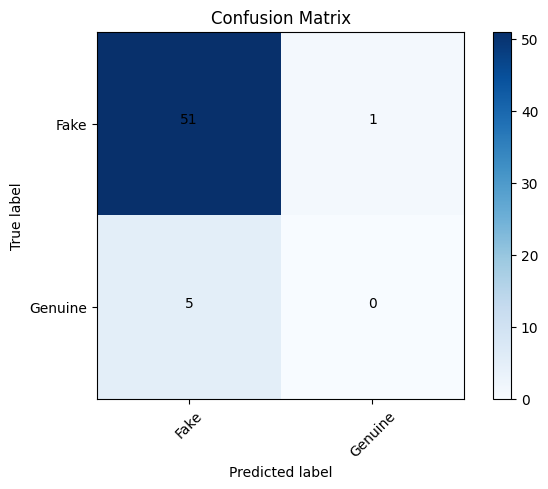

In [10]:
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    target_names = ['Fake', 'Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = cm.max()
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)
plt.show()


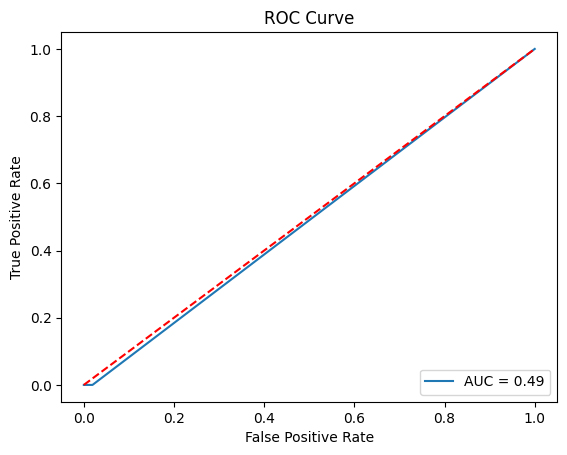

In [11]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, y_pred)

In [12]:
from sklearn.metrics import accuracy_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the model: {accuracy:.2f}")

Accuracy of the model: 0.91


C:\Users\FUJITSU\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
